In [1]:
#imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

<h1>First, we will implement the Mueller potential and simulate some paths on it.

In [2]:
a = np.array([-1,-1,-6.5,0.7])
b = np.array([0,0,11,0.6])
c = np.array([-10,-10,-6.5,0.7])
D = np.array([-200,-100,-170,15])    
X = np.array([1,0,-0.5,-1])
Y = np.array([0,0.5,1.5,1])

<p>The Mueller function is the sum of four Gaussian functions. </p>

In [3]:
def mueller(x):

    fx1 = D[0]*np.exp(a[0]*((x[:,0]-X[0])**(2)) + b[0]*(x[:,0]-X[0])*(x[:,1]-Y[0]) + c[0]*((x[:,1]-Y[0])**(2)))
    fx2 = D[1]*np.exp(a[1]*((x[:,0]-X[1])**(2)) + b[1]*(x[:,0]-X[1])*(x[:,1]-Y[1]) + c[1]*((x[:,1]-Y[1])**(2)))
    fx3 = D[2]*np.exp(a[2]*((x[:,0]-X[2])**(2)) + b[2]*(x[:,0]-X[2])*(x[:,1]-Y[2]) + c[2]*((x[:,1]-Y[2])**(2)))
    fx4 = D[3]*np.exp(a[3]*((x[:,0]-X[3])**(2)) + b[3]*(x[:,0]-X[3])*(x[:,1]-Y[3]) + c[3]*((x[:,1]-Y[3])**(2)))

    U = fx1+fx2+fx3+fx4
    return U

The gradient was computed analytically

In [4]:
def grad_mueller(x):
    x = x.reshape(1, -1)
    
    dVdx1, dVdx2 = 0, 0
    
    
    for i in np.arange(4):
        exp_comp = D[i]*np.exp(a[i]*((x[:,0]-X[i])**(2))+ b[i]*(x[:,0]-X[i])*(x[:,1]-Y[i]) + c[i]*((x[:,1]-Y[i])**(2)))
        dVdx1 += ( exp_comp * (2*a[i]*(x[:,0]-X[i]) + b[i]*(x[:,1]-Y[i])) )
        dVdx2 += ( exp_comp * (b[i]*(x[:,0]-X[i]) + 2*c[i]*(x[:,1]-Y[i])) )
        
    grad = np.array([dVdx1, dVdx2])

    return grad.reshape(1, -1)

<p>These are the starting values for the paths</p>

In [5]:
start_vals = [(-.5, -.5), (-.25, .25), (-1, 1.5), (1, .5)]

<p>Here, the Euler-Maruyama method is used to simulate the paths</p>


In [11]:
delta_t = 10**(-5)
beta = 30**-1
iterations = 10**4
variance = 2*delta_t / beta

terms = np.zeros(shape=(iterations, 2*len(start_vals)))
noise = np.random.default_rng().normal(0, np.sqrt(variance), terms.shape)


for j in np.arange(len(start_vals)):
    terms[0, 2*j:2*j+2] = start_vals[j]
    for i in np.arange(terms.shape[0]-1):
        terms[i+1, 2*j:2*j+2] = terms[i, 2*j:2*j+2] - grad_mueller(terms[i, 2*j:2*j+2])*delta_t + noise[i, 2*j:2*j+2]



<p>Here the paths as well as the level curves are plotted</p>

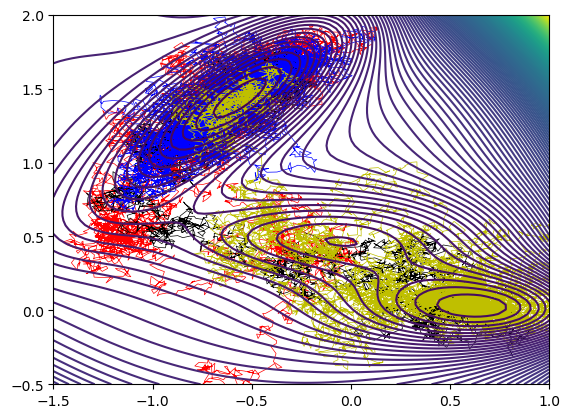

In [13]:
plt.plot(terms[:,0], terms[:,1], 'r-', linewidth=.5)
plt.plot(terms[:,2], terms[:,3], 'k-', linewidth=.5)
plt.plot(terms[:,4], terms[:,5], 'b-', linewidth=.5)
plt.plot(terms[:,6], terms[:,7], 'y-', linewidth=.5)


xmin, xmax, ymin, ymax = -1.5, 1, -.5, 2

xgrid = np.linspace(xmin, xmax, 80)
ygrid = np.linspace(ymin, ymax, 80)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)


gridpoints = np.c_[xgrid.ravel(), ygrid.ravel()]

zgrid = mueller(gridpoints)
zgrid = zgrid.reshape(xgrid.shape)



plt.contour(xgrid, ygrid, zgrid, 200)


plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

plt.show()

<p>Here, we will be doing a stochastic oscillator.
<p>Note that the two dimensional stochastic differential equation is as follows:</p>
$dx(t)=y(t)dt$
    
$dy(t)=-x(t)dt+hdW(t)$

<p>The Euler-Maruyama method to plot this would be</p>
$x_{n+1}=x_n+\Delta ty_n$

$y_{n+1}=y_n - \Delta t x_n + h \Delta W_n$

<p>The backward or implicit Euler-Maruyama method is</p>
$x_{n+1}=x_n+\Delta ty_{n+1}$

$y_{n+1}=y_n-\Delta tx_{n+1}+h\Delta W_n$

This can be rewritten as follows:</p>
$(1+\Delta t^2)x_{n+1}=x_n+\Delta ty_n+h\Delta t\Delta W_n$

$(1+\Delta t^2)y_{n+1}=y_n-\Delta tx_n+h\Delta W_n$
<p>We will use both of these methods with the same random noise vector to simulate the path of a trajectory starting at the point $x_0, y_0=1, 0$. 
<p>However, these methods do not capture the long-term properties of the stochastic differential equation. Instead, consider the relations generated by the partitioned Euler-Maruyama method (PEM), derived from the symplectic method for partitioned ODEs. 
<p>The relations are as follows:</p>
$x_{n+1}=x_n+\Delta ty_n$

$y_{n+1}=y_n-\Delta tx_{n+1}+h\Delta W_n$




In [62]:
deltat = 10**-4
iterations = 10**6
h=.1

terms = np.zeros(shape=(iterations, 6))
terms[0] = np.array([1, 0, 1, 0, 1, 0])
deltaW = np.random.default_rng().normal(0, math.sqrt(deltat), iterations)

A = np.array([[1, deltat],
                [-deltat, 1-deltat**2]])


for n in np.arange(iterations-1):
    #standard Euler-Maruyama
    terms[n+1, 0] = terms[n, 0] + deltat*terms[n, 1]
    terms[n+1, 1] = terms[n, 1] - deltat*terms[n, 0] + deltaW[n]*h
    
    #Modified version - doesn't seem to work at all, plots the same line as before. 
    #terms[n+1, 4] = terms[n, 4] + deltat*terms[n, 5]
    #terms[n+1, 5] = terms[n, 5] - deltat*terms[n+1, 4] + deltaW[n]*h
    

    terms[n+1, 4:6] = np.matmul(A, terms[n, 4:6]) + np.array([0, h*deltaW[n]])



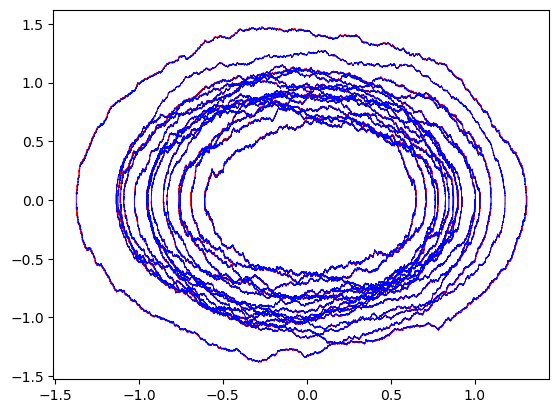

In [63]:
plt.plot(terms[:,0], terms[:,1], 'r-', linewidth=.5)
plt.plot(terms[:,4], terms[:,5], 'b-', linewidth=.5)
plt.show()

In [92]:
def PEM(initpos=np.array([1, 0]), deltat=10**-5, iterations=10**6, h=0.5):
    terms = np.zeros(shape=(iterations, 2))
    terms[0] = initpos
    deltaW = np.random.default_rng().normal(0, math.sqrt(deltat), size=iterations)
    
    for n in range(iterations-1):
        terms[n+1, 0] = terms[n, 0] + deltat*terms[n, 1]
        terms[n+1, 1] = terms[n, 1] - deltat*terms[n+1, 0] + deltaW[n]*h
        
    return terms
    #terms[n+1, 5] = terms[n, 5] - deltat*terms[n+1, 4] + deltaW[n]*h

[ 1.          1.          1.         ... -0.51065824 -0.51069342
 -0.5107286 ]


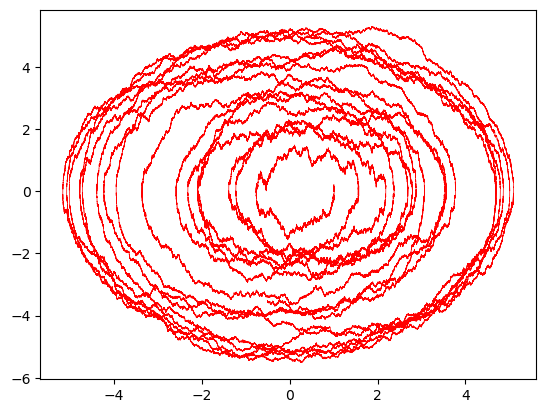

In [91]:
myped = PEM(np.array([1, 0]), deltat=10**-5, iterations=10**7, h=0.5)
print(myped[:,0])
plt.plot(myped[:,0], myped[:,1], 'r-', linewidth=.5)
plt.show()